In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

from IPython.display import Image
import torch
from collections import defaultdict
import imageio
import numpy as np
from tqdm import tqdm

import math

In [2]:
csv_src   = "..\..\..\coords-scattered-hdr.csv"
image_dir = "D:\skies"

In [13]:
skies_data = pd.read_csv(csv_src).sample(frac=1.0, random_state=0)
skies_data

,Date,Time,SunAzimuth,SunAltitude,SamplePatternIndex,SampleAzimuth,SampleAltitude,SunPointAngle,ColorA5,ColorB5,...,1773,1774,1775,1776,1777,1778,1779,1780,u,v
3180,4/14/2013,13:21:23,212.1645,53.3166,32,15.00,33.7490,91.666,1,2,...,0.012263,0.012012,0.011749,0.011510,0.011275,0.011023,0.010809,0.010563,0.588838,0.831546
12607,8/30/2013,9:45:01,127.0108,44.2809,42,165.00,33.7490,31.015,0,2,...,0.000975,0.000920,0.000883,0.000844,0.000790,0.000713,0.000656,0.000616,0.588838,0.168454
15699,9/26/2013,14:10:01,223.1740,36.8177,41,150.00,33.7490,58.291,0,1,...,0.019017,0.018454,0.017885,0.017308,0.016742,0.016165,0.015633,0.015153,0.671621,0.202744
598,11/6/2012,13:13:53,203.0536,28.2029,23,101.25,12.1151,94.420,0,0,...,0.000695,0.000678,0.000663,0.000638,0.000615,0.000588,0.000581,0.000561,0.942607,0.411960
6215,5/12/2013,11:45:01,170.0686,65.5817,20,135.00,12.1151,58.539,1,1,...,0.023026,0.022442,0.021812,0.021215,0.020602,0.019927,0.019382,0.018854,0.819102,0.180898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,8/30/2013,11:15:01,157.7653,54.4977,74,135.00,71.9187,19.933,1,2,...,0.010955,0.010649,0.010332,0.009979,0.009643,0.009283,0.008953,0.008695,0.580999,0.419001
3264,4/14/2013,13:31:53,216.0490,52.2328,36,75.00,33.7490,87.527,2,2,...,0.006221,0.006120,0.006022,0.005930,0.005817,0.005681,0.005517,0.005382,0.831546,0.588838
9845,5/30/2013,12:15:01,187.5801,69.2856,49,270.00,33.7490,56.052,2,2,...,0.000431,0.000441,0.000446,0.000443,0.000422,0.000370,0.000336,0.000315,0.156758,0.500000
10799,7/26/2013,11:15:01,147.9185,63.8681,64,180.00,53.3665,19.418,0,1,...,0.001145,0.001141,0.001119,0.001079,0.001045,0.000989,0.000982,0.000987,0.500000,0.270272


In [6]:
def get_timestamp(row):
    month, day, year = row["Date"].split("/")
    if int(month) < 10:
        month = "0" + month
    if int(day) < 10:
        day = "0" + day
    timestamp = f"{month}/{day}/{year} {row['Time']}"
    
    return timestamp

def row_to_imagepaths(row):
    timestamp = get_timestamp(row)
    
    time_obj = time.strptime(timestamp, "%m/%d/%Y %H:%M:%S")
    date_dir = time.strftime("%Y-%m-%d", time_obj)
    time_dir = time.strftime("%H.%M.%S", time_obj)

    entries = os.scandir(f"{image_dir}\\{date_dir}\\HDR\\{time_dir}")
    jpgs = [
        entry.path
        for entry in entries
        if entry.is_file() and os.path.splitext(entry.name)[-1].lower() == ".jpg"
    ]
    jpgs.sort()

    if len(jpgs) < 8:
        raise BaseException("LESS THAN 8 PICTURES skip this sky")

    return jpgs[:8]

In [12]:
skies_data.iloc[0]

Date                  4/14/2013
Time                   13:21:23
SunAzimuth             212.1645
SunAltitude             53.3166
SamplePatternIndex           32
                        ...    
1778                   0.011023
1779                   0.010809
1780                   0.010563
u                      0.588838
v                      0.831546
Name: 3180, Length: 1453, dtype: object

In [30]:
def get_samples(row, radius=50):
    """
    Returns a (24, 100, 100) tensor
    The 8 samples stacked along the first dimension
    from the lowest exposure tensor[0:3] to the highest tensor[21:]
    """
    images = row_to_imagepaths(row)
    image_arrs = [
        torch.from_numpy(imageio.imread(image)).permute(2, 0, 1)
        for image in images
    ]
    image_arrs = torch.cat(image_arrs, 0)
    
    channels = int(image_arrs.shape[0])
    height = int(image_arrs.shape[1])
    width = int(image_arrs.shape[2])
    crop_index = int((width - height) / 2)
    image_arrs = image_arrs[:, :, crop_index:crop_index + height]
    
    x = int(row["u"] * height)
    y = int(row["v"] * height)
    image_samples = image_arrs[:, y-radius:y+radius, x-radius:x+radius]

    for j in range(image_samples.shape[1]):
        for k in range(image_samples.shape[2]):
            y_offset = abs(j - radius)
            x_offset = abs(k - radius)
            if math.hypot(x_offset, y_offset) > radius:
                image_samples[:, j, k] = torch.zeros(channels)
    
    return image_samples

def display_image(image_tensor):
    plt.imshow(image_tensor.permute(1, 2, 0).numpy())

SampleAzimuth         15.0
SampleAltitude      33.749
u                 0.588838
v                 0.831546
Name: 3180, dtype: object


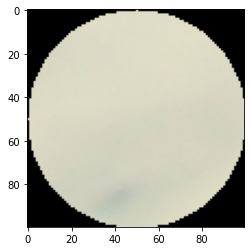

In [39]:
print(skies_data.iloc[0][['SampleAzimuth','SampleAltitude', 'u', 'v']])
display_image(get_samples(skies_data.iloc[0])[18:21])